In [1]:
import os,sys
import torch
import importlib
from utils import options
from utils.util import log

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
argv = ['--group=ETH3D', '--pipeline=LevelS2fM', '--yaml=ETH3D', '--name=facade', '--data.dataset=ETH3D', '--data.scene=facade', '--sfm_mode=full', '--nbv_mode=ours', '--refine_again=false']
opt_cmd = options.parse_arguments(argv)
opt = options.set(opt_cmd=opt_cmd,safe_check=False)

model = importlib.import_module("pipelines.{}".format(opt.pipeline))
m = model.Model(opt)
m.load_dataset(opt)
m.restore_checkpoint(opt)
m.setup_visualizer(opt)
# m.train(opt)

setting configurations...
loading options/base.yaml...
loading options/LevelS2fM.yaml...
loading options/ETH3D.yaml...
* Ablate_config:
   * ba_trad: False
   * dual_field: False
   * refine_again: False
   * sdf_filter: True
   * tri_trad: False
* H: 1033
* RadF:
   * Hash_config:
      * config_file: options/config_hash_rad.json
   * arch:
      * layers: [None, 64, 64, 3]
      * skip: []
* Renderer:
   * rand_rays: 8192
* Res: 100
* SDF:
   * Hash_config:
      * config_file: options/config_hash_sdf.json
   * NN_Init:
      * bias: 2.5
      * scale_mlp: 5
      * tf_init: True
   * VolSDF:
      * beta_init: 0.05
      * beta_speed: 1.0
      * eps: 0.1
      * final_sample_intvs: 64
      * iters_max_st: 20
      * max_upsample_iter: 6
      * outside_scene: builtin
      * rescale: 1.0
      * sample_intvs: 128
      * sdf_threshold: 1e-3
      * volsdf_sampling: False
   * arch:
      * density_activ: softplus
      * layers: [None, 64, 16]
      * skip: []
* W: 1551
* arch:
* 

loading dataset...: 100%|██████████| 76/76 [00:24<00:00,  3.10it/s]


number of samples: 76
initializing weights from scratch...
setting up visualizers...


In [3]:
import importlib
import pdb
import numpy as np
import os, sys, time
import torch
import tqdm
import utils.util as util
from easydict import EasyDict as edict

from utils.util import log
import utils.camera as camera
from pipelines import base
from pipelines import Camera
from pipelines import Point3D
from pipelines import Initialization
from pipelines import Registration
from pipelines import BA
from pipelines import rendering_refine
from pipelines import Initialization_Trad
from pipelines import BA_Trad
from pipelines import Registration_Trad

var = m.load_matches(opt)
pose_graph_path = f"data/{opt.data.dataset}/{opt.data.scene}/pose_graph.npy"
pose_graph = np.load(pose_graph_path, allow_pickle=True)[:]

In [4]:
var.indx_init = pose_graph[:2]
var.imgs_init = m.train_data.all.image[var.indx_init]
var.kypts_init = [var.kypts[i] for i in var.indx_init]
var.intrs_init = m.train_data.all.intr[var.indx_init]
var.mchs_init = [var.matches[i] for i in var.indx_init]
var.inliers_init = [var.masks[i] for i in var.indx_init]
var.gt_depths = None
var.omn_depths = m.train_data.all.depth_omnidata[var.indx_init]
var.omn_norms = m.train_data.all.norm_omnidata[var.indx_init]

Text(0.5, 1.0, 'The Second Image')

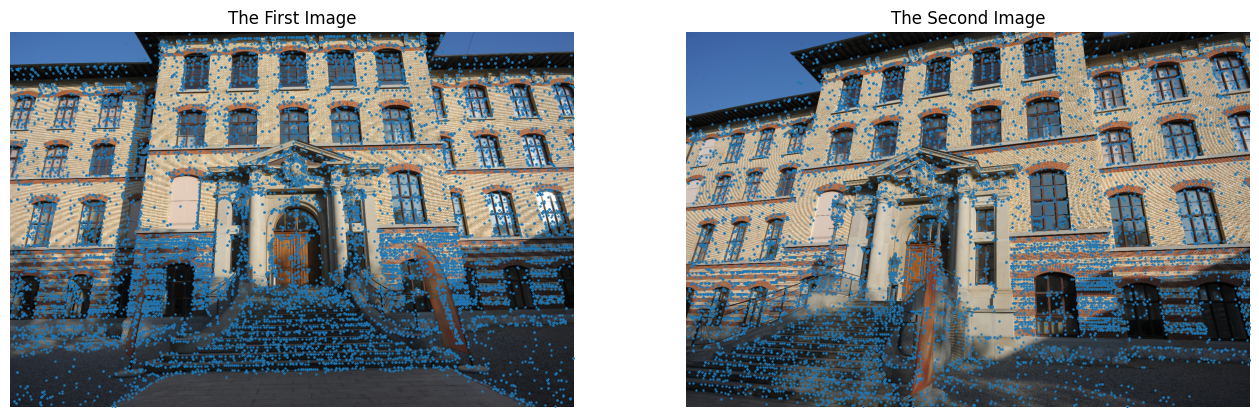

In [5]:
import matplotlib.pyplot as plt 
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
axes[0].imshow(var.imgs_init[0].permute((1,2,0)).cpu().numpy())
axes[0].axis('off')
axes[0].set_title('The First Image')
axes[0].scatter(var.kypts_init[0][:,0].cpu().numpy(), var.kypts_init[0][:,1].cpu().numpy(),s=0.5)
axes[1].imshow(var.imgs_init[1].permute((1,2,0)).cpu().numpy())
axes[1].scatter(var.kypts_init[1][:,0].cpu().numpy(), var.kypts_init[1][:,1].cpu().numpy(),s=0.5)
axes[1].axis('off')
axes[1].set_title('The Second Image')


In [6]:
Initializer = Initialization.Initializer(opt,m.camera_set,m.point_set,m.sdf_func,m.color_func,var,cam_info_reloaded=m.cam_info_reloaded)

/home/xn/anaconda3/envs/levels2fm/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1666642975993/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
Initializer.run(m.camera_set,m.point_set,m.sdf_func,m.color_func,Renderer=m.Renderer)

Initialization:   0%|          | 1/500 [00:01<14:13,  1.71s/it]

5 points algo rot_error:0.03956468030810356
5 points algo translation_error:0.1528813511442228
our algo rot_error:0.02797645330429077
our algo translation_error:0.1532333940267563
PSNR:10.66928482055664
{'reproj_error': 197.91697692871094, 'sdf_surf': 0.01570148766040802, 'eikonal_loss': 0.8386491537094116, 'rgb': 0.26677417755126953, 'DC_Loss': 0.07629722356796265}


Initialization:   0%|          | 2/500 [00:02<07:51,  1.06it/s]

PSNR:11.810840606689453


Initialization:   1%|          | 3/500 [00:02<05:46,  1.43it/s]

PSNR:10.830535888671875


Initialization:   1%|          | 4/500 [00:02<04:41,  1.76it/s]

PSNR:11.680488586425781


Initialization:   1%|          | 5/500 [00:03<04:18,  1.91it/s]

PSNR:12.278419494628906


Initialization:   1%|          | 6/500 [00:03<03:55,  2.10it/s]

PSNR:12.476683616638184


Initialization:   1%|▏         | 7/500 [00:04<03:39,  2.25it/s]

PSNR:12.587417602539062


Initialization:   2%|▏         | 8/500 [00:04<03:37,  2.26it/s]

PSNR:12.281681060791016


Initialization:   2%|▏         | 9/500 [00:04<03:26,  2.38it/s]

PSNR:12.259666442871094


Initialization:   2%|▏         | 10/500 [00:05<03:22,  2.41it/s]

PSNR:12.473360061645508


Initialization:   2%|▏         | 11/500 [00:05<03:18,  2.46it/s]

PSNR:12.368114471435547
{'reproj_error': 169.79042053222656, 'sdf_surf': 0.00742576876655221, 'eikonal_loss': 0.7913761138916016, 'rgb': 0.19845299422740936, 'DC_Loss': 0.061458878219127655}


Initialization:   2%|▏         | 12/500 [00:06<03:20,  2.44it/s]

PSNR:12.639819145202637


Initialization:   3%|▎         | 13/500 [00:06<03:18,  2.45it/s]

PSNR:12.653712272644043


Initialization:   3%|▎         | 14/500 [00:06<03:12,  2.53it/s]

PSNR:12.549920082092285


Initialization:   3%|▎         | 15/500 [00:07<03:18,  2.44it/s]

PSNR:12.498407363891602


Initialization:   3%|▎         | 16/500 [00:07<03:11,  2.52it/s]

PSNR:12.591510772705078


Initialization:   3%|▎         | 17/500 [00:08<03:12,  2.51it/s]

PSNR:12.649131774902344


Initialization:   4%|▎         | 18/500 [00:08<03:17,  2.44it/s]

PSNR:12.774497032165527


Initialization:   4%|▍         | 19/500 [00:08<03:11,  2.51it/s]

PSNR:12.75114917755127


Initialization:   4%|▍         | 20/500 [00:09<03:11,  2.50it/s]

PSNR:12.685395240783691


Initialization:   4%|▍         | 21/500 [00:09<03:09,  2.52it/s]

PSNR:12.702540397644043
{'reproj_error': 134.07110595703125, 'sdf_surf': 0.003352006198838353, 'eikonal_loss': 0.360920786857605, 'rgb': 0.19129006564617157, 'DC_Loss': 0.0463385246694088}


Initialization:   4%|▍         | 22/500 [00:10<03:13,  2.48it/s]

PSNR:12.694629669189453


Initialization:   5%|▍         | 23/500 [00:10<03:10,  2.51it/s]

PSNR:12.748611450195312


Initialization:   5%|▍         | 24/500 [00:10<03:07,  2.54it/s]

PSNR:12.728072166442871


Initialization:   5%|▌         | 25/500 [00:11<03:14,  2.44it/s]

PSNR:12.827659606933594


Initialization:   5%|▌         | 26/500 [00:11<03:07,  2.53it/s]

PSNR:12.541769027709961


Initialization:   5%|▌         | 27/500 [00:12<03:07,  2.52it/s]

PSNR:12.800646781921387


Initialization:   6%|▌         | 28/500 [00:12<03:06,  2.54it/s]

PSNR:12.660112380981445


Initialization:   6%|▌         | 29/500 [00:12<03:09,  2.49it/s]

PSNR:12.702034950256348


Initialization:   6%|▌         | 30/500 [00:13<03:06,  2.52it/s]

PSNR:12.76004695892334


Initialization:   6%|▌         | 31/500 [00:13<03:05,  2.53it/s]

PSNR:12.732124328613281
{'reproj_error': 90.76365661621094, 'sdf_surf': 0.0014836302725598216, 'eikonal_loss': 0.31876617670059204, 'rgb': 0.19019560515880585, 'DC_Loss': 0.032962698489427567}


Initialization:   6%|▋         | 32/500 [00:14<03:11,  2.44it/s]

PSNR:12.723526000976562


Initialization:   7%|▋         | 33/500 [00:14<03:05,  2.52it/s]

PSNR:12.798582077026367


Initialization:   7%|▋         | 34/500 [00:14<03:05,  2.52it/s]

PSNR:12.774837493896484


Initialization:   7%|▋         | 35/500 [00:15<03:03,  2.53it/s]

PSNR:12.71939468383789


Initialization:   7%|▋         | 36/500 [00:15<03:06,  2.49it/s]

PSNR:12.756648063659668


Initialization:   7%|▋         | 37/500 [00:16<03:01,  2.55it/s]

PSNR:12.801973342895508


Initialization:   8%|▊         | 38/500 [00:16<03:01,  2.54it/s]

PSNR:12.854281425476074


Initialization:   8%|▊         | 39/500 [00:16<03:07,  2.45it/s]

PSNR:12.919776916503906


Initialization:   8%|▊         | 40/500 [00:17<03:02,  2.52it/s]

PSNR:12.724615097045898


Initialization:   8%|▊         | 41/500 [00:17<03:02,  2.52it/s]

PSNR:12.84072494506836
{'reproj_error': 59.358116149902344, 'sdf_surf': 0.0008761335629969835, 'eikonal_loss': 0.29636189341545105, 'rgb': 0.18794433772563934, 'DC_Loss': 0.025015147402882576}


Initialization:   8%|▊         | 42/500 [00:18<03:00,  2.54it/s]

PSNR:12.720611572265625


Initialization:   9%|▊         | 43/500 [00:18<03:04,  2.47it/s]

PSNR:12.919166564941406


Initialization:   9%|▉         | 44/500 [00:18<03:03,  2.48it/s]

PSNR:12.796095848083496


Initialization:   9%|▉         | 45/500 [00:19<02:57,  2.56it/s]

PSNR:12.843718528747559


Initialization:   9%|▉         | 46/500 [00:19<03:04,  2.46it/s]

PSNR:12.894816398620605


Initialization:   9%|▉         | 47/500 [00:20<02:58,  2.54it/s]

PSNR:12.89563274383545


Initialization:  10%|▉         | 48/500 [00:20<02:59,  2.52it/s]

PSNR:12.933971405029297


Initialization:  10%|▉         | 49/500 [00:20<03:05,  2.44it/s]

PSNR:12.934603691101074


Initialization:  10%|█         | 50/500 [00:21<02:59,  2.50it/s]

PSNR:12.939146995544434


Initialization:  10%|█         | 51/500 [00:21<02:59,  2.50it/s]

PSNR:13.144062042236328
{'reproj_error': 39.259727478027344, 'sdf_surf': 0.0006780618568882346, 'eikonal_loss': 0.2911882996559143, 'rgb': 0.18062584102153778, 'DC_Loss': 0.022637171670794487}


Initialization:  10%|█         | 52/500 [00:22<02:57,  2.52it/s]

PSNR:13.04140567779541


Initialization:  11%|█         | 53/500 [00:22<03:00,  2.47it/s]

PSNR:13.196972846984863


Initialization:  11%|█         | 54/500 [00:22<02:59,  2.48it/s]

PSNR:13.222949981689453


Initialization:  11%|█         | 55/500 [00:23<02:54,  2.55it/s]

PSNR:13.473834037780762


Initialization:  11%|█         | 56/500 [00:23<03:00,  2.46it/s]

PSNR:13.505934715270996


Initialization:  11%|█▏        | 57/500 [00:24<02:54,  2.53it/s]

PSNR:13.611194610595703


Initialization:  12%|█▏        | 58/500 [00:24<02:55,  2.52it/s]

PSNR:13.878372192382812


Initialization:  12%|█▏        | 59/500 [00:24<02:55,  2.52it/s]

PSNR:13.959735870361328


Initialization:  12%|█▏        | 60/500 [00:25<02:56,  2.49it/s]

PSNR:14.136332511901855


Initialization:  12%|█▏        | 61/500 [00:25<02:55,  2.50it/s]

PSNR:14.22021770477295
{'reproj_error': 21.670833587646484, 'sdf_surf': 0.0006308286101557314, 'eikonal_loss': 0.3077124357223511, 'rgb': 0.15629102289676666, 'DC_Loss': 0.026100482791662216}


Initialization:  12%|█▏        | 62/500 [00:26<02:50,  2.57it/s]

PSNR:14.531515121459961


Initialization:  13%|█▎        | 63/500 [00:26<02:57,  2.46it/s]

PSNR:14.887837409973145


Initialization:  13%|█▎        | 64/500 [00:26<02:51,  2.54it/s]

PSNR:14.875594139099121


Initialization:  13%|█▎        | 65/500 [00:27<02:52,  2.53it/s]

PSNR:14.931445121765137


Initialization:  13%|█▎        | 66/500 [00:27<02:51,  2.52it/s]

PSNR:15.079573631286621


Initialization:  13%|█▎        | 67/500 [00:28<02:55,  2.47it/s]

PSNR:15.127992630004883


Initialization:  14%|█▎        | 68/500 [00:28<02:54,  2.48it/s]

PSNR:15.121816635131836


Initialization:  14%|█▍        | 69/500 [00:28<02:51,  2.51it/s]

PSNR:15.312308311462402


Initialization:  14%|█▍        | 70/500 [00:29<02:54,  2.46it/s]

PSNR:15.454858779907227


Initialization:  14%|█▍        | 71/500 [00:29<02:51,  2.50it/s]

PSNR:15.494234085083008
{'reproj_error': 9.61296558380127, 'sdf_surf': 0.0007195247453637421, 'eikonal_loss': 0.3291463255882263, 'rgb': 0.12547656893730164, 'DC_Loss': 0.03323686495423317}


Initialization:  14%|█▍        | 72/500 [00:30<02:48,  2.54it/s]

PSNR:15.59475326538086


Initialization:  15%|█▍        | 73/500 [00:30<02:48,  2.54it/s]

PSNR:15.655597686767578


Initialization:  15%|█▍        | 74/500 [00:30<02:51,  2.48it/s]

PSNR:15.663415908813477


Initialization:  15%|█▌        | 75/500 [00:31<02:50,  2.49it/s]

PSNR:15.912397384643555


Initialization:  15%|█▌        | 76/500 [00:31<02:45,  2.56it/s]

PSNR:16.032865524291992


Initialization:  15%|█▌        | 77/500 [00:32<02:51,  2.46it/s]

PSNR:16.101167678833008


Initialization:  16%|█▌        | 78/500 [00:32<02:46,  2.53it/s]

PSNR:16.073486328125


Initialization:  16%|█▌        | 79/500 [00:32<02:47,  2.51it/s]

PSNR:16.370502471923828


Initialization:  16%|█▌        | 80/500 [00:33<02:45,  2.53it/s]

PSNR:16.31871795654297


Initialization:  16%|█▌        | 81/500 [00:33<02:48,  2.49it/s]

PSNR:16.658584594726562
{'reproj_error': 6.070725917816162, 'sdf_surf': 0.0015314666088670492, 'eikonal_loss': 0.3332056403160095, 'rgb': 0.10784126818180084, 'DC_Loss': 0.03811603784561157}


Initialization:  16%|█▋        | 82/500 [00:34<02:47,  2.49it/s]

PSNR:16.640472412109375


Initialization:  17%|█▋        | 83/500 [00:34<02:42,  2.57it/s]

PSNR:16.742128372192383


Initialization:  17%|█▋        | 84/500 [00:34<02:49,  2.46it/s]

PSNR:16.607749938964844


Initialization:  17%|█▋        | 85/500 [00:35<02:43,  2.54it/s]

PSNR:16.960403442382812


Initialization:  17%|█▋        | 86/500 [00:35<02:43,  2.53it/s]

PSNR:16.9691162109375


Initialization:  17%|█▋        | 87/500 [00:36<02:48,  2.45it/s]

PSNR:17.083736419677734


Initialization:  18%|█▊        | 88/500 [00:36<02:43,  2.52it/s]

PSNR:17.093202590942383


Initialization:  18%|█▊        | 89/500 [00:36<02:43,  2.52it/s]

PSNR:17.17133140563965


Initialization:  18%|█▊        | 90/500 [00:37<02:41,  2.54it/s]

PSNR:17.0537166595459


Initialization:  18%|█▊        | 91/500 [00:37<02:44,  2.48it/s]

PSNR:17.34096908569336
{'reproj_error': 9.070055961608887, 'sdf_surf': 0.0079072630032897, 'eikonal_loss': 0.3332010507583618, 'rgb': 0.09740370512008667, 'DC_Loss': 0.0401756688952446}


Initialization:  18%|█▊        | 92/500 [00:38<02:44,  2.49it/s]

PSNR:17.356618881225586


Initialization:  19%|█▊        | 93/500 [00:38<02:39,  2.56it/s]

PSNR:17.348215103149414


Initialization:  19%|█▉        | 94/500 [00:38<02:45,  2.46it/s]

PSNR:17.377914428710938


Initialization:  19%|█▉        | 95/500 [00:39<02:39,  2.54it/s]

PSNR:17.406999588012695


Initialization:  19%|█▉        | 96/500 [00:39<02:40,  2.52it/s]

PSNR:17.583721160888672


Initialization:  19%|█▉        | 97/500 [00:39<02:38,  2.54it/s]

PSNR:17.323869705200195


Initialization:  20%|█▉        | 98/500 [00:40<02:41,  2.49it/s]

PSNR:17.590017318725586


Initialization:  20%|█▉        | 99/500 [00:40<02:40,  2.49it/s]

PSNR:17.403427124023438


Initialization:  20%|██        | 100/500 [00:41<02:36,  2.56it/s]

PSNR:17.713634490966797


Initialization:  20%|██        | 101/500 [00:41<02:41,  2.46it/s]

PSNR:17.556941986083984
{'reproj_error': 8.83950424194336, 'sdf_surf': 0.007965530268847942, 'eikonal_loss': 0.3269954323768616, 'rgb': 0.09258989989757538, 'DC_Loss': 0.041843611747026443}


Initialization:  20%|██        | 102/500 [00:41<02:36,  2.54it/s]

PSNR:17.736722946166992


Initialization:  21%|██        | 103/500 [00:42<02:37,  2.52it/s]

PSNR:17.60232162475586


Initialization:  21%|██        | 104/500 [00:42<02:41,  2.45it/s]

PSNR:17.69478416442871


Initialization:  21%|██        | 105/500 [00:43<02:37,  2.51it/s]

PSNR:17.60260772705078


Initialization:  21%|██        | 106/500 [00:43<02:37,  2.51it/s]

PSNR:17.851945877075195


Initialization:  21%|██▏       | 107/500 [00:43<02:32,  2.57it/s]

PSNR:17.770008087158203


Initialization:  22%|██▏       | 108/500 [00:44<02:39,  2.46it/s]

PSNR:17.671358108520508


Initialization:  22%|██▏       | 109/500 [00:44<02:38,  2.47it/s]

PSNR:17.73823356628418


Initialization:  22%|██▏       | 110/500 [00:45<02:33,  2.54it/s]

PSNR:17.734697341918945


Initialization:  22%|██▏       | 111/500 [00:45<02:38,  2.45it/s]

PSNR:17.936777114868164
{'reproj_error': 7.564145565032959, 'sdf_surf': 0.007450122851878405, 'eikonal_loss': 0.31914979219436646, 'rgb': 0.08758334815502167, 'DC_Loss': 0.043467678129673004}


Initialization:  22%|██▏       | 112/500 [00:45<02:33,  2.53it/s]

PSNR:17.895227432250977


Initialization:  23%|██▎       | 113/500 [00:46<02:33,  2.52it/s]

PSNR:17.965410232543945


Initialization:  23%|██▎       | 114/500 [00:46<02:32,  2.53it/s]

PSNR:18.139986038208008


Initialization:  23%|██▎       | 115/500 [00:47<02:35,  2.48it/s]

PSNR:17.912057876586914


Initialization:  23%|██▎       | 116/500 [00:47<02:30,  2.55it/s]

PSNR:17.886716842651367


Initialization:  23%|██▎       | 117/500 [00:47<02:31,  2.54it/s]

PSNR:18.04884910583496


Initialization:  24%|██▎       | 118/500 [00:48<02:36,  2.45it/s]

PSNR:17.917007446289062


Initialization:  24%|██▍       | 119/500 [00:48<02:31,  2.52it/s]

PSNR:17.753578186035156


Initialization:  24%|██▍       | 120/500 [00:49<02:30,  2.52it/s]

PSNR:17.852693557739258


Initialization:  24%|██▍       | 121/500 [00:49<02:30,  2.52it/s]

PSNR:17.958721160888672
{'reproj_error': 7.1393818855285645, 'sdf_surf': 0.006634183693677187, 'eikonal_loss': 0.31486162543296814, 'rgb': 0.08665788173675537, 'DC_Loss': 0.04367576912045479}


Initialization:  24%|██▍       | 122/500 [00:49<02:32,  2.47it/s]

PSNR:17.993404388427734


Initialization:  25%|██▍       | 123/500 [00:50<02:32,  2.48it/s]

PSNR:18.08043670654297


Initialization:  25%|██▍       | 124/500 [00:50<02:27,  2.55it/s]

PSNR:18.10401725769043


Initialization:  25%|██▌       | 125/500 [00:51<02:32,  2.46it/s]

PSNR:18.056276321411133


Initialization:  25%|██▌       | 126/500 [00:51<02:27,  2.53it/s]

PSNR:18.1242618560791


Initialization:  25%|██▌       | 127/500 [00:51<02:28,  2.52it/s]

PSNR:18.10964012145996


Initialization:  26%|██▌       | 128/500 [00:52<02:26,  2.53it/s]

PSNR:17.9733943939209


Initialization:  26%|██▌       | 129/500 [00:52<02:29,  2.48it/s]

PSNR:18.436058044433594


Initialization:  26%|██▌       | 130/500 [00:53<02:28,  2.49it/s]

PSNR:18.212425231933594


Initialization:  26%|██▌       | 131/500 [00:53<02:23,  2.56it/s]

PSNR:18.200103759765625
{'reproj_error': 6.349453926086426, 'sdf_surf': 0.005511581897735596, 'eikonal_loss': 0.31026989221572876, 'rgb': 0.08410923182964325, 'DC_Loss': 0.04495906084775925}


Initialization:  26%|██▋       | 132/500 [00:53<02:29,  2.47it/s]

PSNR:18.157123565673828


Initialization:  27%|██▋       | 133/500 [00:54<02:24,  2.54it/s]

PSNR:18.13058090209961


Initialization:  27%|██▋       | 134/500 [00:54<02:24,  2.53it/s]

PSNR:18.19781494140625


Initialization:  27%|██▋       | 135/500 [00:55<02:23,  2.54it/s]

PSNR:18.2331485748291


Initialization:  27%|██▋       | 136/500 [00:55<02:26,  2.49it/s]

PSNR:18.091880798339844


Initialization:  27%|██▋       | 137/500 [00:55<02:25,  2.49it/s]

PSNR:18.278244018554688


Initialization:  28%|██▊       | 138/500 [00:56<02:21,  2.56it/s]

PSNR:18.231159210205078


Initialization:  28%|██▊       | 139/500 [00:56<02:26,  2.46it/s]

PSNR:18.147911071777344


Initialization:  28%|██▊       | 140/500 [00:57<02:22,  2.52it/s]

PSNR:18.102558135986328


Initialization:  28%|██▊       | 141/500 [00:57<02:22,  2.52it/s]

PSNR:18.321516036987305
{'reproj_error': 5.2364068031311035, 'sdf_surf': 0.004150076303631067, 'eikonal_loss': 0.3070400357246399, 'rgb': 0.08138902485370636, 'DC_Loss': 0.0450640469789505}


Initialization:  28%|██▊       | 142/500 [00:57<02:19,  2.57it/s]

PSNR:17.958600997924805


Initialization:  29%|██▊       | 143/500 [00:58<02:24,  2.47it/s]

PSNR:18.380332946777344


Initialization:  29%|██▉       | 144/500 [00:58<02:22,  2.50it/s]

PSNR:18.43935203552246


Initialization:  29%|██▉       | 145/500 [00:59<02:19,  2.54it/s]

PSNR:18.275970458984375


Initialization:  29%|██▉       | 146/500 [00:59<02:24,  2.45it/s]

PSNR:18.426280975341797


Initialization:  29%|██▉       | 147/500 [00:59<02:19,  2.52it/s]

PSNR:18.40287971496582


Initialization:  30%|██▉       | 148/500 [01:00<02:20,  2.51it/s]

PSNR:18.46171760559082


Initialization:  30%|██▉       | 149/500 [01:00<02:18,  2.53it/s]

PSNR:18.434324264526367


Initialization:  30%|███       | 150/500 [01:01<02:20,  2.49it/s]

PSNR:18.340831756591797


Initialization:  30%|███       | 151/500 [01:01<02:21,  2.47it/s]

PSNR:18.385141372680664
{'reproj_error': 4.579939365386963, 'sdf_surf': 0.004055109340697527, 'eikonal_loss': 0.305318146944046, 'rgb': 0.08068442344665527, 'DC_Loss': 0.04507647454738617}


Initialization:  30%|███       | 152/500 [01:01<02:16,  2.55it/s]

PSNR:18.405704498291016


Initialization:  31%|███       | 153/500 [01:02<02:21,  2.45it/s]

PSNR:18.59941864013672


Initialization:  31%|███       | 154/500 [01:02<02:17,  2.53it/s]

PSNR:18.560474395751953


Initialization:  31%|███       | 155/500 [01:03<02:17,  2.51it/s]

PSNR:18.230783462524414


Initialization:  31%|███       | 156/500 [01:03<02:21,  2.43it/s]

PSNR:18.526412963867188


Initialization:  31%|███▏      | 157/500 [01:03<02:16,  2.51it/s]

PSNR:18.505573272705078


Initialization:  32%|███▏      | 158/500 [01:04<02:16,  2.50it/s]

PSNR:18.48379135131836


Initialization:  32%|███▏      | 159/500 [01:04<02:14,  2.53it/s]

PSNR:18.592931747436523


Initialization:  32%|███▏      | 160/500 [01:05<02:16,  2.48it/s]

PSNR:18.425403594970703


Initialization:  32%|███▏      | 161/500 [01:05<02:15,  2.51it/s]

PSNR:18.315284729003906
{'reproj_error': 3.939171075820923, 'sdf_surf': 0.0034940692130476236, 'eikonal_loss': 0.30216801166534424, 'rgb': 0.08087395131587982, 'DC_Loss': 0.04625784605741501}


Initialization:  32%|███▏      | 162/500 [01:05<02:12,  2.55it/s]

PSNR:18.680238723754883


Initialization:  33%|███▎      | 163/500 [01:06<02:17,  2.44it/s]

PSNR:18.523372650146484


Initialization:  33%|███▎      | 164/500 [01:06<02:13,  2.52it/s]

PSNR:18.53411293029785


Initialization:  33%|███▎      | 165/500 [01:07<02:13,  2.51it/s]

PSNR:18.688873291015625


Initialization:  33%|███▎      | 166/500 [01:07<02:12,  2.53it/s]

PSNR:18.587825775146484


Initialization:  33%|███▎      | 167/500 [01:07<02:14,  2.48it/s]

PSNR:18.503196716308594


Initialization:  34%|███▎      | 168/500 [01:08<02:13,  2.49it/s]

PSNR:18.552196502685547


Initialization:  34%|███▍      | 169/500 [01:08<02:09,  2.55it/s]

PSNR:18.64198875427246


Initialization:  34%|███▍      | 170/500 [01:09<02:14,  2.46it/s]

PSNR:18.716400146484375


Initialization:  34%|███▍      | 171/500 [01:09<02:08,  2.57it/s]

PSNR:18.755117416381836
{'reproj_error': 3.2529687881469727, 'sdf_surf': 0.002812366234138608, 'eikonal_loss': 0.2998366355895996, 'rgb': 0.07711251825094223, 'DC_Loss': 0.046592921018600464}


Initialization:  34%|███▍      | 172/500 [01:09<02:14,  2.44it/s]

PSNR:18.57291603088379


Initialization:  35%|███▍      | 173/500 [01:10<02:28,  2.20it/s]

PSNR:18.557260513305664


Initialization:  35%|███▍      | 174/500 [01:11<02:38,  2.05it/s]

PSNR:18.61480140686035


Initialization:  35%|███▌      | 175/500 [01:11<02:43,  1.99it/s]

PSNR:18.557525634765625


Initialization:  35%|███▌      | 176/500 [01:12<02:45,  1.95it/s]

PSNR:18.68173599243164


Initialization:  35%|███▌      | 177/500 [01:12<02:47,  1.92it/s]

PSNR:18.6018123626709


Initialization:  36%|███▌      | 178/500 [01:13<02:51,  1.88it/s]

PSNR:18.58864402770996


Initialization:  36%|███▌      | 179/500 [01:13<02:51,  1.87it/s]

PSNR:18.774625778198242


Initialization:  36%|███▌      | 180/500 [01:14<02:54,  1.83it/s]

PSNR:18.70781707763672


Initialization:  36%|███▌      | 181/500 [01:14<02:52,  1.84it/s]

PSNR:18.630233764648438
{'reproj_error': 2.757110595703125, 'sdf_surf': 0.0025131716392934322, 'eikonal_loss': 0.2982438802719116, 'rgb': 0.07636101543903351, 'DC_Loss': 0.04784546047449112}


Initialization:  36%|███▋      | 182/500 [01:15<02:51,  1.85it/s]

PSNR:18.833301544189453


Initialization:  37%|███▋      | 183/500 [01:16<02:53,  1.82it/s]

PSNR:18.687379837036133


Initialization:  37%|███▋      | 184/500 [01:16<02:54,  1.81it/s]

PSNR:18.67803955078125


Initialization:  37%|███▋      | 185/500 [01:17<02:52,  1.82it/s]

PSNR:18.635404586791992


Initialization:  37%|███▋      | 186/500 [01:17<02:50,  1.84it/s]

PSNR:18.797510147094727


Initialization:  37%|███▋      | 187/500 [01:18<02:49,  1.84it/s]

PSNR:18.688785552978516


Initialization:  38%|███▊      | 188/500 [01:18<02:48,  1.85it/s]

PSNR:18.822343826293945


Initialization:  38%|███▊      | 189/500 [01:19<02:48,  1.85it/s]

PSNR:18.693195343017578


Initialization:  38%|███▊      | 190/500 [01:19<02:46,  1.86it/s]

PSNR:18.72806167602539


Initialization:  38%|███▊      | 191/500 [01:20<02:46,  1.86it/s]

PSNR:18.87804412841797
{'reproj_error': 2.4895899295806885, 'sdf_surf': 0.0022493137512356043, 'eikonal_loss': 0.29723840951919556, 'rgb': 0.07403631508350372, 'DC_Loss': 0.04830368235707283}


Initialization:  38%|███▊      | 192/500 [01:20<02:45,  1.86it/s]

PSNR:18.61117172241211


Initialization:  39%|███▊      | 193/500 [01:21<02:47,  1.83it/s]

PSNR:18.636987686157227


Initialization:  39%|███▉      | 194/500 [01:21<02:46,  1.84it/s]

PSNR:18.71744155883789


Initialization:  39%|███▉      | 195/500 [01:22<02:47,  1.82it/s]

PSNR:18.58962631225586


Initialization:  39%|███▉      | 196/500 [01:23<02:46,  1.83it/s]

PSNR:18.71152687072754


Initialization:  39%|███▉      | 197/500 [01:23<02:44,  1.84it/s]

PSNR:18.721235275268555


Initialization:  40%|███▉      | 198/500 [01:24<02:43,  1.85it/s]

PSNR:18.842498779296875


Initialization:  40%|███▉      | 199/500 [01:24<02:42,  1.85it/s]

PSNR:18.819276809692383


Initialization:  40%|████      | 200/500 [01:25<02:43,  1.83it/s]

PSNR:18.639328002929688


Initialization:  40%|████      | 201/500 [01:25<02:42,  1.84it/s]

PSNR:18.682430267333984
{'reproj_error': 2.2631795406341553, 'sdf_surf': 0.0022291531786322594, 'eikonal_loss': 0.2959025502204895, 'rgb': 0.07616269588470459, 'DC_Loss': 0.04866575449705124}


Initialization:  40%|████      | 202/500 [01:26<02:43,  1.82it/s]

PSNR:18.970600128173828


Initialization:  41%|████      | 203/500 [01:26<02:42,  1.83it/s]

PSNR:18.911724090576172


Initialization:  41%|████      | 204/500 [01:27<02:40,  1.84it/s]

PSNR:18.793128967285156


Initialization:  41%|████      | 205/500 [01:27<02:42,  1.82it/s]

PSNR:18.738506317138672


Initialization:  41%|████      | 206/500 [01:28<02:40,  1.83it/s]

PSNR:18.802019119262695


Initialization:  41%|████▏     | 207/500 [01:29<02:39,  1.84it/s]

PSNR:18.809288024902344


Initialization:  42%|████▏     | 208/500 [01:29<02:37,  1.85it/s]

PSNR:18.928192138671875


Initialization:  42%|████▏     | 209/500 [01:30<02:37,  1.85it/s]

PSNR:18.828908920288086


Initialization:  42%|████▏     | 210/500 [01:30<02:36,  1.86it/s]

PSNR:18.685115814208984


Initialization:  42%|████▏     | 211/500 [01:31<02:38,  1.83it/s]

PSNR:18.829143524169922
{'reproj_error': 1.9561909437179565, 'sdf_surf': 0.0022573168389499187, 'eikonal_loss': 0.2953321039676666, 'rgb': 0.07508059591054916, 'DC_Loss': 0.04792129620909691}


Initialization:  42%|████▏     | 212/500 [01:31<02:39,  1.81it/s]

PSNR:18.852359771728516


Initialization:  43%|████▎     | 213/500 [01:32<02:37,  1.82it/s]

PSNR:18.76892852783203


Initialization:  43%|████▎     | 214/500 [01:32<02:36,  1.83it/s]

PSNR:18.75520896911621


Initialization:  43%|████▎     | 215/500 [01:33<02:36,  1.82it/s]

PSNR:18.906993865966797


Initialization:  43%|████▎     | 216/500 [01:33<02:34,  1.83it/s]

PSNR:18.9195556640625


Initialization:  43%|████▎     | 217/500 [01:34<02:33,  1.84it/s]

PSNR:18.72779083251953


Initialization:  44%|████▎     | 218/500 [01:35<02:32,  1.85it/s]

PSNR:18.987985610961914


Initialization:  44%|████▍     | 219/500 [01:35<02:31,  1.85it/s]

PSNR:19.066749572753906


Initialization:  44%|████▍     | 220/500 [01:36<02:30,  1.86it/s]

PSNR:18.658700942993164


Initialization:  44%|████▍     | 221/500 [01:36<02:30,  1.86it/s]

PSNR:19.0694522857666
{'reproj_error': 1.7533881664276123, 'sdf_surf': 0.002010916592553258, 'eikonal_loss': 0.2945054769515991, 'rgb': 0.07294993102550507, 'DC_Loss': 0.05024625360965729}


Initialization:  44%|████▍     | 222/500 [01:37<02:29,  1.86it/s]

PSNR:19.00934410095215


Initialization:  45%|████▍     | 223/500 [01:37<02:28,  1.86it/s]

PSNR:18.8270206451416


Initialization:  45%|████▍     | 224/500 [01:38<02:30,  1.83it/s]

PSNR:18.959318161010742


Initialization:  45%|████▌     | 225/500 [01:38<02:30,  1.82it/s]

PSNR:19.032011032104492


Initialization:  45%|████▌     | 226/500 [01:39<02:30,  1.82it/s]

PSNR:18.93174934387207


Initialization:  45%|████▌     | 227/500 [01:39<02:31,  1.80it/s]

PSNR:18.907764434814453


Initialization:  46%|████▌     | 228/500 [01:40<02:31,  1.79it/s]

PSNR:19.256345748901367


Initialization:  46%|████▌     | 229/500 [01:41<02:28,  1.82it/s]

PSNR:19.02855110168457


Initialization:  46%|████▌     | 230/500 [01:41<02:27,  1.84it/s]

PSNR:18.98617172241211


Initialization:  46%|████▌     | 231/500 [01:42<02:26,  1.84it/s]

PSNR:19.061767578125
{'reproj_error': 1.5257371664047241, 'sdf_surf': 0.001708967611193657, 'eikonal_loss': 0.2936774492263794, 'rgb': 0.07305110991001129, 'DC_Loss': 0.04998600110411644}


Initialization:  46%|████▋     | 232/500 [01:42<02:24,  1.85it/s]

PSNR:19.024988174438477


Initialization:  47%|████▋     | 233/500 [01:43<02:23,  1.86it/s]

PSNR:19.17363166809082


Initialization:  47%|████▋     | 234/500 [01:43<02:23,  1.86it/s]

PSNR:19.04432487487793


Initialization:  47%|████▋     | 235/500 [01:44<02:23,  1.85it/s]

PSNR:19.074323654174805


Initialization:  47%|████▋     | 236/500 [01:44<02:24,  1.83it/s]

PSNR:19.113258361816406


Initialization:  47%|████▋     | 237/500 [01:45<02:23,  1.84it/s]

PSNR:19.069520950317383


Initialization:  48%|████▊     | 238/500 [01:45<02:23,  1.82it/s]

PSNR:19.000579833984375


Initialization:  48%|████▊     | 239/500 [01:46<02:22,  1.83it/s]

PSNR:19.06974220275879


Initialization:  48%|████▊     | 240/500 [01:47<02:23,  1.82it/s]

PSNR:18.9898738861084


Initialization:  48%|████▊     | 241/500 [01:47<02:21,  1.83it/s]

PSNR:19.134418487548828
{'reproj_error': 1.433503270149231, 'sdf_surf': 0.0016031399136409163, 'eikonal_loss': 0.2928738296031952, 'rgb': 0.07228469848632812, 'DC_Loss': 0.050450075417757034}


Initialization:  48%|████▊     | 242/500 [01:48<02:20,  1.84it/s]

PSNR:19.211572647094727


Initialization:  49%|████▊     | 243/500 [01:48<02:21,  1.82it/s]

PSNR:19.022926330566406


Initialization:  49%|████▉     | 244/500 [01:49<02:21,  1.81it/s]

PSNR:18.84934425354004


Initialization:  49%|████▉     | 245/500 [01:49<02:19,  1.82it/s]

PSNR:19.028606414794922


Initialization:  49%|████▉     | 246/500 [01:50<02:18,  1.84it/s]

PSNR:19.112594604492188


Initialization:  49%|████▉     | 247/500 [01:50<02:01,  2.08it/s]

PSNR:18.849517822265625


Initialization:  50%|████▉     | 248/500 [01:50<01:50,  2.27it/s]

PSNR:18.9726505279541


Initialization:  50%|████▉     | 249/500 [01:51<01:59,  2.10it/s]

PSNR:19.34959602355957


Initialization:  50%|█████     | 250/500 [01:52<02:03,  2.02it/s]

PSNR:19.08596420288086


Initialization:  50%|█████     | 251/500 [01:52<02:06,  1.96it/s]

PSNR:18.998981475830078
{'reproj_error': 1.3432888984680176, 'sdf_surf': 0.0015109420055523515, 'eikonal_loss': 0.2921556234359741, 'rgb': 0.07249002158641815, 'DC_Loss': 0.04946477711200714}


Initialization:  50%|█████     | 252/500 [01:53<02:08,  1.94it/s]

PSNR:19.180028915405273


Initialization:  51%|█████     | 253/500 [01:53<02:08,  1.92it/s]

PSNR:19.126192092895508


Initialization:  51%|█████     | 254/500 [01:54<02:11,  1.87it/s]

PSNR:19.2362003326416


Initialization:  51%|█████     | 255/500 [01:54<02:11,  1.87it/s]

PSNR:19.288820266723633


Initialization:  51%|█████     | 256/500 [01:55<02:10,  1.87it/s]

PSNR:19.214874267578125


Initialization:  51%|█████▏    | 257/500 [01:55<02:10,  1.86it/s]

PSNR:19.136688232421875


Initialization:  52%|█████▏    | 258/500 [01:56<02:12,  1.83it/s]

PSNR:19.13728904724121


Initialization:  52%|█████▏    | 259/500 [01:56<02:10,  1.85it/s]

PSNR:19.06667709350586


Initialization:  52%|█████▏    | 260/500 [01:57<02:09,  1.85it/s]

PSNR:19.067285537719727


Initialization:  52%|█████▏    | 261/500 [01:58<02:10,  1.83it/s]

PSNR:19.319570541381836
{'reproj_error': 1.0832469463348389, 'sdf_surf': 0.00150877155829221, 'eikonal_loss': 0.29110288619995117, 'rgb': 0.0696924477815628, 'DC_Loss': 0.050379928201436996}


Initialization:  52%|█████▏    | 262/500 [01:58<02:11,  1.81it/s]

PSNR:19.217391967773438


Initialization:  53%|█████▎    | 263/500 [01:59<02:09,  1.83it/s]

PSNR:18.988815307617188


Initialization:  53%|█████▎    | 264/500 [01:59<02:08,  1.84it/s]

PSNR:19.227155685424805


Initialization:  53%|█████▎    | 265/500 [02:00<02:07,  1.84it/s]

PSNR:19.07339859008789


Initialization:  53%|█████▎    | 266/500 [02:00<02:08,  1.82it/s]

PSNR:19.122655868530273


Initialization:  53%|█████▎    | 267/500 [02:01<02:08,  1.81it/s]

PSNR:19.25481414794922


Initialization:  54%|█████▎    | 268/500 [02:01<02:07,  1.82it/s]

PSNR:19.03999137878418


Initialization:  54%|█████▍    | 269/500 [02:02<02:05,  1.84it/s]

PSNR:19.25794792175293


Initialization:  54%|█████▍    | 270/500 [02:03<02:06,  1.82it/s]

PSNR:19.37608528137207


Initialization:  54%|█████▍    | 271/500 [02:03<02:07,  1.80it/s]

PSNR:19.14621925354004
{'reproj_error': 0.9930256605148315, 'sdf_surf': 0.001312239677645266, 'eikonal_loss': 0.2897641062736511, 'rgb': 0.07045672833919525, 'DC_Loss': 0.05049706622958183}


Initialization:  54%|█████▍    | 272/500 [02:04<02:05,  1.82it/s]

PSNR:19.099300384521484


Initialization:  55%|█████▍    | 273/500 [02:04<02:06,  1.80it/s]

PSNR:19.23891830444336


Initialization:  55%|█████▍    | 274/500 [02:05<02:05,  1.79it/s]

PSNR:19.414440155029297


Initialization:  55%|█████▌    | 275/500 [02:05<02:03,  1.82it/s]

PSNR:19.20794105529785


Initialization:  55%|█████▌    | 276/500 [02:06<02:03,  1.81it/s]

PSNR:19.25476837158203


Initialization:  55%|█████▌    | 277/500 [02:06<02:02,  1.82it/s]

PSNR:19.319541931152344


Initialization:  56%|█████▌    | 278/500 [02:07<02:01,  1.83it/s]

PSNR:19.310791015625


Initialization:  56%|█████▌    | 279/500 [02:07<02:02,  1.81it/s]

PSNR:19.146808624267578


Initialization:  56%|█████▌    | 280/500 [02:08<02:02,  1.80it/s]

PSNR:19.13811492919922


Initialization:  56%|█████▌    | 281/500 [02:09<02:02,  1.79it/s]

PSNR:19.218034744262695
{'reproj_error': 1.2022496461868286, 'sdf_surf': 0.0013922620564699173, 'eikonal_loss': 0.28860580921173096, 'rgb': 0.06921520084142685, 'DC_Loss': 0.05049780756235123}


Initialization:  56%|█████▋    | 282/500 [02:09<02:00,  1.81it/s]

PSNR:19.481952667236328


Initialization:  57%|█████▋    | 283/500 [02:10<01:59,  1.82it/s]

PSNR:19.356958389282227


Initialization:  57%|█████▋    | 284/500 [02:10<01:59,  1.81it/s]

PSNR:19.30970001220703


Initialization:  57%|█████▋    | 285/500 [02:11<01:59,  1.79it/s]

PSNR:19.244997024536133


Initialization:  57%|█████▋    | 286/500 [02:11<01:58,  1.80it/s]

PSNR:19.45888900756836


Initialization:  57%|█████▋    | 287/500 [02:12<01:56,  1.82it/s]

PSNR:19.08827781677246


Initialization:  58%|█████▊    | 288/500 [02:12<01:56,  1.82it/s]

PSNR:19.213150024414062


Initialization:  58%|█████▊    | 289/500 [02:13<01:56,  1.82it/s]

PSNR:19.533849716186523


Initialization:  58%|█████▊    | 290/500 [02:14<01:56,  1.80it/s]

PSNR:19.085233688354492


Initialization:  58%|█████▊    | 291/500 [02:14<01:54,  1.82it/s]

PSNR:19.306001663208008
{'reproj_error': 1.0087387561798096, 'sdf_surf': 0.0012755603529512882, 'eikonal_loss': 0.2884514331817627, 'rgb': 0.06880489736795425, 'DC_Loss': 0.050813574343919754}


Initialization:  58%|█████▊    | 292/500 [02:15<01:52,  1.84it/s]

PSNR:19.36581039428711


Initialization:  59%|█████▊    | 293/500 [02:15<01:52,  1.85it/s]

PSNR:19.377483367919922


Initialization:  59%|█████▉    | 294/500 [02:16<01:51,  1.85it/s]

PSNR:19.402868270874023


Initialization:  59%|█████▉    | 295/500 [02:16<01:51,  1.83it/s]

PSNR:19.143604278564453


Initialization:  59%|█████▉    | 296/500 [02:17<01:50,  1.84it/s]

PSNR:19.16587257385254


Initialization:  59%|█████▉    | 297/500 [02:17<01:49,  1.85it/s]

PSNR:19.51719093322754


Initialization:  60%|█████▉    | 298/500 [02:18<01:49,  1.85it/s]

PSNR:19.33221435546875


Initialization:  60%|█████▉    | 299/500 [02:18<01:49,  1.83it/s]

PSNR:19.308177947998047


Initialization:  60%|██████    | 300/500 [02:19<01:48,  1.85it/s]

PSNR:19.40555191040039


Initialization:  60%|██████    | 301/500 [02:20<01:47,  1.85it/s]

PSNR:19.378339767456055
{'reproj_error': 0.9853305816650391, 'sdf_surf': 0.0012775000650435686, 'eikonal_loss': 0.2884916663169861, 'rgb': 0.06864313781261444, 'DC_Loss': 0.05056343600153923}


Initialization:  60%|██████    | 302/500 [02:20<01:48,  1.82it/s]

PSNR:19.429933547973633


Initialization:  61%|██████    | 303/500 [02:21<01:48,  1.81it/s]

PSNR:19.28109359741211


Initialization:  61%|██████    | 304/500 [02:21<01:49,  1.80it/s]

PSNR:19.277240753173828


Initialization:  61%|██████    | 305/500 [02:22<01:49,  1.79it/s]

PSNR:19.376380920410156


Initialization:  61%|██████    | 306/500 [02:22<01:47,  1.81it/s]

PSNR:19.30183982849121


Initialization:  61%|██████▏   | 307/500 [02:23<01:47,  1.80it/s]

PSNR:19.43952178955078


Initialization:  62%|██████▏   | 308/500 [02:23<01:45,  1.82it/s]

PSNR:19.52716636657715


Initialization:  62%|██████▏   | 309/500 [02:24<01:45,  1.80it/s]

PSNR:19.383798599243164


Initialization:  62%|██████▏   | 310/500 [02:25<01:44,  1.81it/s]

PSNR:19.349287033081055


Initialization:  62%|██████▏   | 311/500 [02:25<01:44,  1.80it/s]

PSNR:19.241031646728516
{'reproj_error': 1.0080630779266357, 'sdf_surf': 0.0011692715343087912, 'eikonal_loss': 0.2875518798828125, 'rgb': 0.06940361857414246, 'DC_Loss': 0.05108301341533661}


Initialization:  62%|██████▏   | 312/500 [02:26<01:44,  1.80it/s]

PSNR:19.491933822631836


Initialization:  63%|██████▎   | 313/500 [02:26<01:42,  1.82it/s]

PSNR:19.601242065429688


Initialization:  63%|██████▎   | 314/500 [02:27<01:41,  1.83it/s]

PSNR:19.427942276000977


Initialization:  63%|██████▎   | 315/500 [02:27<01:42,  1.80it/s]

PSNR:19.446786880493164


Initialization:  63%|██████▎   | 316/500 [02:28<01:42,  1.80it/s]

PSNR:19.348976135253906


Initialization:  63%|██████▎   | 317/500 [02:28<01:42,  1.79it/s]

PSNR:19.467864990234375


Initialization:  64%|██████▎   | 318/500 [02:29<01:41,  1.79it/s]

PSNR:19.493362426757812


Initialization:  64%|██████▍   | 319/500 [02:30<01:40,  1.81it/s]

PSNR:19.216262817382812


Initialization:  64%|██████▍   | 320/500 [02:30<01:38,  1.83it/s]

PSNR:19.506004333496094


Initialization:  64%|██████▍   | 321/500 [02:31<01:37,  1.84it/s]

PSNR:19.47810935974121
{'reproj_error': 0.8876376152038574, 'sdf_surf': 0.0011435786727815866, 'eikonal_loss': 0.2873668968677521, 'rgb': 0.06762074679136276, 'DC_Loss': 0.05179278180003166}


Initialization:  64%|██████▍   | 322/500 [02:31<01:34,  1.89it/s]

PSNR:19.667924880981445


Initialization:  65%|██████▍   | 323/500 [02:31<01:26,  2.04it/s]

PSNR:19.299274444580078


Initialization:  65%|██████▍   | 324/500 [02:32<01:29,  1.96it/s]

PSNR:19.506032943725586


Initialization:  65%|██████▌   | 325/500 [02:33<01:31,  1.91it/s]

PSNR:19.277807235717773


Initialization:  65%|██████▌   | 326/500 [02:33<01:31,  1.90it/s]

PSNR:19.521760940551758


Initialization:  65%|██████▌   | 327/500 [02:34<01:33,  1.86it/s]

PSNR:19.54787254333496


Initialization:  66%|██████▌   | 328/500 [02:34<01:33,  1.83it/s]

PSNR:19.406312942504883


Initialization:  66%|██████▌   | 329/500 [02:35<01:32,  1.84it/s]

PSNR:19.525163650512695


Initialization:  66%|██████▌   | 330/500 [02:35<01:33,  1.82it/s]

PSNR:19.50421905517578


Initialization:  66%|██████▌   | 331/500 [02:36<01:32,  1.82it/s]

PSNR:19.661808013916016
{'reproj_error': 0.8493835926055908, 'sdf_surf': 0.001101651811040938, 'eikonal_loss': 0.28637635707855225, 'rgb': 0.0650596171617508, 'DC_Loss': 0.0521647073328495}


Initialization:  66%|██████▋   | 332/500 [02:36<01:32,  1.82it/s]

PSNR:19.471860885620117


Initialization:  67%|██████▋   | 333/500 [02:37<01:31,  1.82it/s]

PSNR:19.436573028564453


Initialization:  67%|██████▋   | 334/500 [02:38<01:30,  1.82it/s]

PSNR:19.40604591369629


Initialization:  67%|██████▋   | 335/500 [02:38<01:30,  1.83it/s]

PSNR:19.574440002441406


Initialization:  67%|██████▋   | 336/500 [02:39<01:30,  1.82it/s]

PSNR:19.449798583984375


Initialization:  67%|██████▋   | 337/500 [02:39<01:28,  1.83it/s]

PSNR:19.553752899169922


Initialization:  68%|██████▊   | 338/500 [02:40<01:27,  1.84it/s]

PSNR:19.52804946899414


Initialization:  68%|██████▊   | 339/500 [02:40<01:27,  1.85it/s]

PSNR:19.591562271118164


Initialization:  68%|██████▊   | 340/500 [02:41<01:26,  1.86it/s]

PSNR:19.694833755493164


Initialization:  68%|██████▊   | 341/500 [02:41<01:26,  1.83it/s]

PSNR:19.735063552856445
{'reproj_error': 0.8472845554351807, 'sdf_surf': 0.0011209031799808145, 'eikonal_loss': 0.2861133813858032, 'rgb': 0.06597355008125305, 'DC_Loss': 0.05148956924676895}


Initialization:  68%|██████▊   | 342/500 [02:42<01:25,  1.84it/s]

PSNR:19.479747772216797


Initialization:  69%|██████▊   | 343/500 [02:42<01:26,  1.82it/s]

PSNR:19.614763259887695


Initialization:  69%|██████▉   | 344/500 [02:43<01:26,  1.81it/s]

PSNR:19.34375


Initialization:  69%|██████▉   | 345/500 [02:44<01:25,  1.82it/s]

PSNR:19.641109466552734


Initialization:  69%|██████▉   | 346/500 [02:44<01:24,  1.82it/s]

PSNR:19.47542381286621


Initialization:  69%|██████▉   | 347/500 [02:45<01:24,  1.80it/s]

PSNR:19.694591522216797


Initialization:  70%|██████▉   | 348/500 [02:45<01:24,  1.80it/s]

PSNR:19.500141143798828


Initialization:  70%|██████▉   | 349/500 [02:46<01:23,  1.81it/s]

PSNR:19.609464645385742


Initialization:  70%|███████   | 350/500 [02:46<01:23,  1.80it/s]

PSNR:19.43565559387207


Initialization:  70%|███████   | 351/500 [02:47<01:21,  1.82it/s]

PSNR:19.584091186523438
{'reproj_error': 0.8022677898406982, 'sdf_surf': 0.0010878128232434392, 'eikonal_loss': 0.28616198897361755, 'rgb': 0.06642872840166092, 'DC_Loss': 0.051404472440481186}


Initialization:  70%|███████   | 352/500 [02:47<01:21,  1.83it/s]

PSNR:19.322893142700195


Initialization:  71%|███████   | 353/500 [02:48<01:21,  1.81it/s]

PSNR:19.542531967163086


Initialization:  71%|███████   | 354/500 [02:49<01:20,  1.82it/s]

PSNR:19.8356990814209


Initialization:  71%|███████   | 355/500 [02:49<01:20,  1.81it/s]

PSNR:19.698577880859375


Initialization:  71%|███████   | 356/500 [02:50<01:18,  1.83it/s]

PSNR:19.704769134521484


Initialization:  71%|███████▏  | 357/500 [02:50<01:19,  1.80it/s]

PSNR:19.645355224609375


Initialization:  72%|███████▏  | 358/500 [02:51<01:19,  1.79it/s]

PSNR:19.697734832763672


Initialization:  72%|███████▏  | 359/500 [02:51<01:17,  1.82it/s]

PSNR:19.79414939880371


Initialization:  72%|███████▏  | 360/500 [02:52<01:17,  1.81it/s]

PSNR:19.699142456054688


Initialization:  72%|███████▏  | 361/500 [02:52<01:16,  1.83it/s]

PSNR:19.58206558227539
{'reproj_error': 0.8282501697540283, 'sdf_surf': 0.001043033553287387, 'eikonal_loss': 0.2858896255493164, 'rgb': 0.06665673106908798, 'DC_Loss': 0.05086994543671608}


Initialization:  72%|███████▏  | 362/500 [02:53<01:14,  1.84it/s]

PSNR:19.620922088623047


Initialization:  73%|███████▎  | 363/500 [02:53<01:15,  1.81it/s]

PSNR:19.884035110473633


Initialization:  73%|███████▎  | 364/500 [02:54<01:14,  1.83it/s]

PSNR:19.826236724853516


Initialization:  73%|███████▎  | 365/500 [02:55<01:14,  1.81it/s]

PSNR:19.46045684814453


Initialization:  73%|███████▎  | 366/500 [02:55<01:13,  1.83it/s]

PSNR:19.68838882446289


Initialization:  73%|███████▎  | 367/500 [02:56<01:13,  1.82it/s]

PSNR:19.699363708496094


Initialization:  74%|███████▎  | 368/500 [02:56<01:12,  1.83it/s]

PSNR:19.826522827148438


Initialization:  74%|███████▍  | 369/500 [02:57<01:11,  1.83it/s]

PSNR:19.5932559967041


Initialization:  74%|███████▍  | 370/500 [02:57<01:11,  1.82it/s]

PSNR:19.621707916259766


Initialization:  74%|███████▍  | 371/500 [02:58<01:10,  1.82it/s]

PSNR:19.574613571166992
{'reproj_error': 0.7930156588554382, 'sdf_surf': 0.001078123110346496, 'eikonal_loss': 0.2844369411468506, 'rgb': 0.06594657897949219, 'DC_Loss': 0.05234109237790108}


Initialization:  74%|███████▍  | 372/500 [02:58<01:10,  1.81it/s]

PSNR:19.661640167236328


Initialization:  75%|███████▍  | 373/500 [02:59<01:09,  1.82it/s]

PSNR:19.667558670043945


Initialization:  75%|███████▍  | 374/500 [02:59<01:08,  1.83it/s]

PSNR:19.868337631225586


Initialization:  75%|███████▌  | 375/500 [03:00<01:08,  1.81it/s]

PSNR:19.870588302612305


Initialization:  75%|███████▌  | 376/500 [03:01<01:07,  1.83it/s]

PSNR:19.644187927246094


Initialization:  75%|███████▌  | 377/500 [03:01<01:06,  1.84it/s]

PSNR:19.927915573120117


Initialization:  76%|███████▌  | 378/500 [03:02<01:07,  1.82it/s]

PSNR:19.660966873168945


Initialization:  76%|███████▌  | 379/500 [03:02<01:07,  1.80it/s]

PSNR:19.673885345458984


Initialization:  76%|███████▌  | 380/500 [03:03<01:06,  1.80it/s]

PSNR:19.582365036010742


Initialization:  76%|███████▌  | 381/500 [03:03<01:05,  1.81it/s]

PSNR:19.946762084960938
{'reproj_error': 0.8301048278808594, 'sdf_surf': 0.0010588900186121464, 'eikonal_loss': 0.28454113006591797, 'rgb': 0.06320337951183319, 'DC_Loss': 0.05211417376995087}


Initialization:  76%|███████▋  | 382/500 [03:04<01:04,  1.83it/s]

PSNR:19.996540069580078


Initialization:  77%|███████▋  | 383/500 [03:04<01:04,  1.81it/s]

PSNR:19.797649383544922


Initialization:  77%|███████▋  | 384/500 [03:05<01:03,  1.83it/s]

PSNR:19.656429290771484


Initialization:  77%|███████▋  | 385/500 [03:06<01:02,  1.84it/s]

PSNR:19.72812271118164


Initialization:  77%|███████▋  | 386/500 [03:06<01:01,  1.85it/s]

PSNR:19.84341049194336


Initialization:  77%|███████▋  | 387/500 [03:07<01:01,  1.84it/s]

PSNR:19.754545211791992


Initialization:  78%|███████▊  | 388/500 [03:07<01:01,  1.83it/s]

PSNR:19.525888442993164


Initialization:  78%|███████▊  | 389/500 [03:08<01:01,  1.81it/s]

PSNR:19.693666458129883


Initialization:  78%|███████▊  | 390/500 [03:08<01:00,  1.83it/s]

PSNR:19.730876922607422


Initialization:  78%|███████▊  | 391/500 [03:09<00:59,  1.84it/s]

PSNR:20.080097198486328
{'reproj_error': 0.7657519578933716, 'sdf_surf': 0.0009772656485438347, 'eikonal_loss': 0.2839847803115845, 'rgb': 0.06256885826587677, 'DC_Loss': 0.05267254263162613}


Initialization:  78%|███████▊  | 392/500 [03:09<00:58,  1.85it/s]

PSNR:19.61979103088379


Initialization:  79%|███████▊  | 393/500 [03:10<00:58,  1.82it/s]

PSNR:19.733530044555664


Initialization:  79%|███████▉  | 394/500 [03:10<00:57,  1.84it/s]

PSNR:19.69245147705078


Initialization:  79%|███████▉  | 395/500 [03:11<00:56,  1.85it/s]

PSNR:19.949947357177734


Initialization:  79%|███████▉  | 396/500 [03:12<00:56,  1.83it/s]

PSNR:19.76487922668457


Initialization:  79%|███████▉  | 397/500 [03:12<00:54,  1.87it/s]

PSNR:19.819122314453125


Initialization:  80%|███████▉  | 398/500 [03:12<00:45,  2.23it/s]

PSNR:19.48014259338379


Initialization:  80%|███████▉  | 399/500 [03:13<00:48,  2.09it/s]

PSNR:19.774211883544922


Initialization:  80%|████████  | 400/500 [03:13<00:49,  2.01it/s]

PSNR:19.7347354888916


Initialization:  80%|████████  | 401/500 [03:14<00:50,  1.97it/s]

PSNR:19.941272735595703
{'reproj_error': 0.7514514327049255, 'sdf_surf': 0.0009570152033120394, 'eikonal_loss': 0.2842976748943329, 'rgb': 0.06264401227235794, 'DC_Loss': 0.05312182381749153}


Initialization:  80%|████████  | 402/500 [03:14<00:51,  1.90it/s]

PSNR:19.816930770874023


Initialization:  81%|████████  | 403/500 [03:15<00:51,  1.89it/s]

PSNR:19.67425537109375


Initialization:  81%|████████  | 404/500 [03:16<00:51,  1.88it/s]

PSNR:19.70207405090332


Initialization:  81%|████████  | 405/500 [03:16<00:50,  1.88it/s]

PSNR:20.00084686279297


Initialization:  81%|████████  | 406/500 [03:17<00:50,  1.84it/s]

PSNR:20.020769119262695


Initialization:  81%|████████▏ | 407/500 [03:17<00:50,  1.85it/s]

PSNR:19.83866310119629


Initialization:  82%|████████▏ | 408/500 [03:18<00:50,  1.82it/s]

PSNR:19.978187561035156


Initialization:  82%|████████▏ | 409/500 [03:18<00:49,  1.84it/s]

PSNR:20.025081634521484


Initialization:  82%|████████▏ | 410/500 [03:19<00:48,  1.84it/s]

PSNR:19.82406997680664


Initialization:  82%|████████▏ | 411/500 [03:19<00:48,  1.85it/s]

PSNR:19.76253318786621
{'reproj_error': 0.7593913078308105, 'sdf_surf': 0.0009162378846667707, 'eikonal_loss': 0.2841532230377197, 'rgb': 0.06395450234413147, 'DC_Loss': 0.0516648143529892}


Initialization:  82%|████████▏ | 412/500 [03:20<00:47,  1.84it/s]

PSNR:19.788129806518555


Initialization:  83%|████████▎ | 413/500 [03:20<00:47,  1.83it/s]

PSNR:19.68596649169922


Initialization:  83%|████████▎ | 414/500 [03:21<00:46,  1.84it/s]

PSNR:19.930513381958008


Initialization:  83%|████████▎ | 415/500 [03:22<00:46,  1.82it/s]

PSNR:20.067007064819336


Initialization:  83%|████████▎ | 416/500 [03:22<00:45,  1.83it/s]

PSNR:19.534557342529297


Initialization:  83%|████████▎ | 417/500 [03:23<00:45,  1.84it/s]

PSNR:19.8215274810791


Initialization:  84%|████████▎ | 418/500 [03:23<00:45,  1.82it/s]

PSNR:19.568540573120117


Initialization:  84%|████████▍ | 419/500 [03:24<00:44,  1.83it/s]

PSNR:19.87166976928711


Initialization:  84%|████████▍ | 420/500 [03:24<00:44,  1.81it/s]

PSNR:19.846710205078125


Initialization:  84%|████████▍ | 421/500 [03:25<00:43,  1.82it/s]

PSNR:19.666030883789062
{'reproj_error': 0.7638981342315674, 'sdf_surf': 0.000884974142536521, 'eikonal_loss': 0.2838400602340698, 'rgb': 0.06434101611375809, 'DC_Loss': 0.0520138256251812}


Initialization:  84%|████████▍ | 422/500 [03:25<00:43,  1.81it/s]

PSNR:19.763916015625


Initialization:  85%|████████▍ | 423/500 [03:26<00:42,  1.83it/s]

PSNR:19.761972427368164


Initialization:  85%|████████▍ | 424/500 [03:27<00:41,  1.81it/s]

PSNR:19.869338989257812


Initialization:  85%|████████▌ | 425/500 [03:27<00:41,  1.83it/s]

PSNR:19.90465545654297


Initialization:  85%|████████▌ | 426/500 [03:28<00:40,  1.84it/s]

PSNR:19.631103515625


Initialization:  85%|████████▌ | 427/500 [03:28<00:39,  1.85it/s]

PSNR:19.882923126220703


Initialization:  86%|████████▌ | 428/500 [03:29<00:38,  1.85it/s]

PSNR:19.863393783569336


Initialization:  86%|████████▌ | 429/500 [03:29<00:38,  1.83it/s]

PSNR:19.814777374267578


Initialization:  86%|████████▌ | 430/500 [03:30<00:38,  1.84it/s]

PSNR:19.857593536376953


Initialization:  86%|████████▌ | 431/500 [03:30<00:37,  1.85it/s]

PSNR:19.847721099853516
{'reproj_error': 0.7323797345161438, 'sdf_surf': 0.0008819544455036521, 'eikonal_loss': 0.2832791209220886, 'rgb': 0.06358487904071808, 'DC_Loss': 0.05275941640138626}


Initialization:  86%|████████▋ | 432/500 [03:31<00:37,  1.83it/s]

PSNR:20.073936462402344


Initialization:  87%|████████▋ | 433/500 [03:31<00:36,  1.83it/s]

PSNR:19.899518966674805


Initialization:  87%|████████▋ | 434/500 [03:32<00:35,  1.84it/s]

PSNR:19.93218231201172


Initialization:  87%|████████▋ | 435/500 [03:33<00:35,  1.82it/s]

PSNR:20.012310028076172


Initialization:  87%|████████▋ | 436/500 [03:33<00:35,  1.80it/s]

PSNR:19.87137794494629


Initialization:  87%|████████▋ | 437/500 [03:34<00:34,  1.82it/s]

PSNR:20.087282180786133


Initialization:  88%|████████▊ | 438/500 [03:34<00:33,  1.83it/s]

PSNR:19.90959358215332


Initialization:  88%|████████▊ | 439/500 [03:35<00:33,  1.82it/s]

PSNR:19.918670654296875


Initialization:  88%|████████▊ | 440/500 [03:35<00:32,  1.83it/s]

PSNR:20.0784912109375


Initialization:  88%|████████▊ | 441/500 [03:36<00:32,  1.81it/s]

PSNR:20.08447265625
{'reproj_error': 0.7382448315620422, 'sdf_surf': 0.0008584521128796041, 'eikonal_loss': 0.28285831212997437, 'rgb': 0.06149643659591675, 'DC_Loss': 0.0533905066549778}


Initialization:  88%|████████▊ | 442/500 [03:36<00:31,  1.83it/s]

PSNR:19.93288230895996


Initialization:  89%|████████▊ | 443/500 [03:37<00:30,  1.84it/s]

PSNR:19.925867080688477


Initialization:  89%|████████▉ | 444/500 [03:37<00:30,  1.82it/s]

PSNR:19.982791900634766


Initialization:  89%|████████▉ | 445/500 [03:38<00:29,  1.83it/s]

PSNR:19.904415130615234


Initialization:  89%|████████▉ | 446/500 [03:39<00:29,  1.82it/s]

PSNR:19.565702438354492


Initialization:  89%|████████▉ | 447/500 [03:39<00:28,  1.83it/s]

PSNR:20.168033599853516


Initialization:  90%|████████▉ | 448/500 [03:40<00:28,  1.84it/s]

PSNR:19.887556076049805


Initialization:  90%|████████▉ | 449/500 [03:40<00:28,  1.82it/s]

PSNR:19.96846580505371


Initialization:  90%|█████████ | 450/500 [03:41<00:27,  1.80it/s]

PSNR:19.962617874145508


Initialization:  90%|█████████ | 451/500 [03:41<00:27,  1.79it/s]

PSNR:20.21274757385254
{'reproj_error': 0.7112738490104675, 'sdf_surf': 0.0007961613009683788, 'eikonal_loss': 0.28302133083343506, 'rgb': 0.06020435690879822, 'DC_Loss': 0.052402351051568985}


Initialization:  90%|█████████ | 452/500 [03:42<00:26,  1.82it/s]

PSNR:20.000137329101562


Initialization:  91%|█████████ | 453/500 [03:42<00:26,  1.80it/s]

PSNR:19.81450843811035


Initialization:  91%|█████████ | 454/500 [03:43<00:25,  1.82it/s]

PSNR:19.94750213623047


Initialization:  91%|█████████ | 455/500 [03:44<00:24,  1.80it/s]

PSNR:19.961069107055664


Initialization:  91%|█████████ | 456/500 [03:44<00:24,  1.82it/s]

PSNR:20.031787872314453


Initialization:  91%|█████████▏| 457/500 [03:45<00:23,  1.81it/s]

PSNR:20.03365707397461


Initialization:  92%|█████████▏| 458/500 [03:45<00:23,  1.83it/s]

PSNR:19.82721710205078


Initialization:  92%|█████████▏| 459/500 [03:46<00:22,  1.81it/s]

PSNR:19.935680389404297


Initialization:  92%|█████████▏| 460/500 [03:46<00:22,  1.81it/s]

PSNR:19.954076766967773


Initialization:  92%|█████████▏| 461/500 [03:47<00:21,  1.81it/s]

PSNR:19.947317123413086
{'reproj_error': 0.734950065612793, 'sdf_surf': 0.0008020161185413599, 'eikonal_loss': 0.282459020614624, 'rgb': 0.061777886003255844, 'DC_Loss': 0.05234750732779503}


Initialization:  92%|█████████▏| 462/500 [03:47<00:20,  1.82it/s]

PSNR:20.104978561401367


Initialization:  93%|█████████▎| 463/500 [03:48<00:20,  1.81it/s]

PSNR:20.026653289794922


Initialization:  93%|█████████▎| 464/500 [03:48<00:19,  1.83it/s]

PSNR:19.727296829223633


Initialization:  93%|█████████▎| 465/500 [03:49<00:18,  1.84it/s]

PSNR:19.981081008911133


Initialization:  93%|█████████▎| 466/500 [03:50<00:18,  1.85it/s]

PSNR:20.025415420532227


Initialization:  93%|█████████▎| 467/500 [03:50<00:18,  1.82it/s]

PSNR:20.04556655883789


Initialization:  94%|█████████▎| 468/500 [03:51<00:17,  1.83it/s]

PSNR:19.909107208251953


Initialization:  94%|█████████▍| 469/500 [03:51<00:16,  1.84it/s]

PSNR:20.117591857910156


Initialization:  94%|█████████▍| 470/500 [03:52<00:16,  1.83it/s]

PSNR:19.902862548828125


Initialization:  94%|█████████▍| 471/500 [03:52<00:15,  1.84it/s]

PSNR:20.211345672607422
{'reproj_error': 0.7288768887519836, 'sdf_surf': 0.0008021426037885249, 'eikonal_loss': 0.2824268937110901, 'rgb': 0.061200499534606934, 'DC_Loss': 0.052087120711803436}


Initialization:  94%|█████████▍| 472/500 [03:53<00:15,  1.84it/s]

PSNR:20.001861572265625


Initialization:  95%|█████████▍| 473/500 [03:53<00:13,  2.01it/s]

PSNR:20.127466201782227


Initialization:  95%|█████████▍| 474/500 [03:54<00:11,  2.22it/s]

PSNR:19.951751708984375


Initialization:  95%|█████████▌| 475/500 [03:54<00:11,  2.10it/s]

PSNR:19.972232818603516


Initialization:  95%|█████████▌| 476/500 [03:55<00:11,  2.01it/s]

PSNR:20.0484676361084


Initialization:  95%|█████████▌| 477/500 [03:55<00:11,  1.94it/s]

PSNR:20.003625869750977


Initialization:  96%|█████████▌| 478/500 [03:56<00:11,  1.92it/s]

PSNR:19.981525421142578


Initialization:  96%|█████████▌| 479/500 [03:56<00:11,  1.91it/s]

PSNR:20.0064640045166


Initialization:  96%|█████████▌| 480/500 [03:57<00:10,  1.90it/s]

PSNR:20.03369140625


Initialization:  96%|█████████▌| 481/500 [03:57<00:10,  1.89it/s]

PSNR:19.886734008789062
{'reproj_error': 0.6801473498344421, 'sdf_surf': 0.0007534853648394346, 'eikonal_loss': 0.282919704914093, 'rgb': 0.06221763789653778, 'DC_Loss': 0.05282224714756012}


Initialization:  96%|█████████▋| 482/500 [03:58<00:09,  1.86it/s]

PSNR:19.904869079589844


Initialization:  97%|█████████▋| 483/500 [03:58<00:09,  1.86it/s]

PSNR:20.095447540283203


Initialization:  97%|█████████▋| 484/500 [03:59<00:08,  1.86it/s]

PSNR:20.120180130004883


Initialization:  97%|█████████▋| 485/500 [03:59<00:08,  1.86it/s]

PSNR:19.908611297607422


Initialization:  97%|█████████▋| 486/500 [04:00<00:07,  1.84it/s]

PSNR:20.045948028564453


Initialization:  97%|█████████▋| 487/500 [04:01<00:07,  1.82it/s]

PSNR:20.113096237182617


Initialization:  98%|█████████▊| 488/500 [04:01<00:06,  1.83it/s]

PSNR:19.920406341552734


Initialization:  98%|█████████▊| 489/500 [04:02<00:06,  1.81it/s]

PSNR:19.880096435546875


Initialization:  98%|█████████▊| 490/500 [04:02<00:05,  1.83it/s]

PSNR:19.941417694091797


Initialization:  98%|█████████▊| 491/500 [04:03<00:04,  1.84it/s]

PSNR:20.02747344970703
{'reproj_error': 0.6894001960754395, 'sdf_surf': 0.0007412514532916248, 'eikonal_loss': 0.2825959324836731, 'rgb': 0.06213609129190445, 'DC_Loss': 0.052127864211797714}


Initialization:  98%|█████████▊| 492/500 [04:03<00:04,  1.85it/s]

PSNR:19.986473083496094


Initialization:  99%|█████████▊| 493/500 [04:04<00:03,  1.86it/s]

PSNR:20.034273147583008


Initialization:  99%|█████████▉| 494/500 [04:04<00:03,  1.85it/s]

PSNR:20.2375431060791


Initialization:  99%|█████████▉| 495/500 [04:05<00:02,  1.83it/s]

PSNR:20.047988891601562


Initialization:  99%|█████████▉| 496/500 [04:05<00:02,  1.82it/s]

PSNR:20.181142807006836


Initialization:  99%|█████████▉| 497/500 [04:06<00:01,  1.83it/s]

PSNR:20.16324806213379


Initialization: 100%|█████████▉| 498/500 [04:07<00:01,  1.82it/s]

PSNR:20.210865020751953


Initialization: 100%|█████████▉| 499/500 [04:07<00:00,  1.83it/s]

PSNR:20.097692489624023


PSNR:20.047203063964844
----------------final loss-----------------
{'reproj_error': 0.6917275786399841, 'sdf_surf': 0.0007693360676057637, 'eikonal_loss': 0.2821235656738281, 'rgb': 0.061044078320264816, 'DC_Loss': 0.05204834043979645, 'all': 90.0771484375}
Triangulation ratio 549/552


rot_error:0.02797645330429077
t_error:0.1532333940267563


In [44]:
camera0.intrinsic

tensor([[852.6700,   0.0000, 778.9225],
        [  0.0000, 851.9976, 515.6829],
        [  0.0000,   0.0000,   1.0000]], device='cuda:0')

In [53]:
camera0 = m.camera_set.cameras[0]
camera1 = m.camera_set.cameras[1]

In [54]:
pose0 = camera0.get_pose().detach()[0]
pose1 = camera1.get_pose().detach()[0]

In [55]:
points3D = torch.cat([_.xyz for _ in m.point_set.pointset])

In [56]:
from notebooks import vis_3d

In [59]:
fig = vis_3d.init_figure()
vis_3d.plot_points(fig, points3D.cpu().numpy(), color='rgba(255,0,0,1)', ps=1)
vis_3d.plot_camera(fig, pose0.cpu().numpy()[:3,:3], pose0.cpu().numpy()[:3,3], camera0.intrinsic.cpu().numpy(), color='rgba(0,255,0,1)', name='Camera 0')
vis_3d.plot_camera(fig, pose1.cpu().numpy()[:3,:3], pose1.cpu().numpy()[:3,3], camera1.intrinsic.cpu().numpy(), color='rgba(0,128,64,1)', name='Camera 1')
fig.show()

In [48]:
pose0.shape

torch.Size([1, 3, 4])